# Make money in stocks

## Part 4: LSTM Prediction & MACD Strategy—LSTM Prediction

### Import packages

In [1]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import json
import time
import math
import numpy as np
import pandas as pd
import datetime as dt
from numpy import newaxis
from keras.layers import Dense, Activation, Dropout, LSTM
from keras.models import Sequential, load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge

from math import pi,sqrt,exp,pow,log
from numpy.linalg import det, inv
from abc import ABCMeta, abstractmethod
from sklearn import cluster

import statsmodels.api as sm 
import scipy.stats as scs
import scipy.optimize as sco
import scipy.interpolate as sci
from scipy import stats
from scipy.stats import norm

import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

### Step1: Import data.

In [3]:
sp500 = pd.read_html("https://en.wikipedia.org/wiki/List_of_S%26P_500_companies")[0]
sp500["Symbol"] = sp500["Symbol"].str.replace(".", "-", regex=True)
sectors=sp500['GICS Sector'].unique()[0:5]
sp50=sp500[sp500['GICS Sector'].isin(sectors)]
sp50=sp50[sp50['Date first added']<'2017-01-01']
sp50=sp50[0:50]
company_symbol=sp50['Symbol'].tolist()
sp50_data=yf.download(tickers=company_symbol,start="2017-10-01",group_by='ticker')

[*********************100%***********************]  50 of 50 completed


### Step2: Construct stock_price_pridictfunction.

Now we design a function to predict stock prices of 50 companies in the last 3 months (2022-08-27 to 2022-11-27).

- Input: stock price data of selected companies in the past 5 years, the symbol of the company we wan to predict.
- Output: the true value and predicted value of close prices for the company in the last 3 months.

In [4]:
def stock_price_pridict(df,stock_name):
    sequence_length=10;
    normalise= True
    batch_size=512
    input_dim=1
    input_timesteps=9
    neurons=50
    epochs=500
    prediction_len=1
    dense_output=1
    drop_out=0
    
    #train-test split
    data=df[stock_name]
    cols = ['Close']
    len_df=data.shape[0]
    data_train = data.get(cols)['2017-10-01':'2022-08-15'].values
    data_test  = data.get(cols)['2022-08-16':'2022-11-28'].values
    len_train  = len(data_train)
    len_test   = len(data_test)
    len_train_windows = None
    
    #get_test_data    
    data_windows = []
    for i in range(len_test - sequence_length):
        data_windows.append(data_test[i:i+sequence_length])
    data_windows = np.array(data_windows).astype(float)
    
    # get original y_test
    y_test_ori = data_windows[:, -1, [0]]
    print('y_test_ori.shape',y_test_ori.shape)
    window_data=data_windows
    win_num=window_data.shape[0]
    col_num=window_data.shape[2]
    normalised_data = []
    record_min=[]
    record_max=[]
    
    #normalize
    for win_i in range(0,win_num):
        normalised_window = []
        for col_i in range(0,col_num):
            temp_col=window_data[win_i,:,col_i]
            temp_min=min(temp_col)
            if col_i==0:
                record_min.append(temp_min)#record min
                temp_col=temp_col-temp_min
                temp_max=max(temp_col)
            if col_i==0:
                record_max.append(temp_max)#record max
                temp_col=temp_col/temp_max
                normalised_window.append(temp_col)
        normalised_window = np.array(normalised_window).T
        normalised_data.append(normalised_window)
    normalised_data=np.array(normalised_data)
    
    # normalised_data=window_data
    data_windows=normalised_data#get_test_data
    x_test = data_windows[:, :-1]
    y_test = data_windows[:, -1, [0]]

    #get_train_data 
    data_windows = []
    for i in range(len_train - sequence_length):
        data_windows.append(data_train[i:i+sequence_length])
    data_windows = np.array(data_windows).astype(float)
  
    window_data=data_windows
    win_num=window_data.shape[0]
    col_num=window_data.shape[2]

    normalised_data = []
    for win_i in range(0,win_num):
        normalised_window = []
        for col_i in range(0,col_num):
            temp_col=window_data[win_i,:,col_i]
            temp_min=min(temp_col)
            temp_col=temp_col-temp_min
            temp_max=max(temp_col)
            temp_col=temp_col/temp_max
            normalised_window.append(temp_col)
        normalised_window = np.array(normalised_window).T
        normalised_data.append(normalised_window)
    normalised_data=np.array(normalised_data)

    # normalised_data=window_data
    data_windows=normalised_data
    x_train = data_windows[:, :-1]
    y_train = data_windows[:, -1,[0]]
    
    # LSTM MODEL
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(input_timesteps, input_dim), return_sequences = True))
    model.add(Dropout(drop_out))
    model.add(LSTM(neurons,return_sequences = True))
    model.add(LSTM(neurons,return_sequences =False))
    model.add(Dropout(drop_out))
    model.add(Dense(dense_output, activation='linear'))
    model.compile(loss='mean_squared_error',
                optimizer='adam')
    
    # Fit the model
    model.fit(x_train,y_train,epochs=epochs,batch_size=batch_size)
    
    #multi sequence predict
    data=x_test
    prediction_seqs = []
    window_size=sequence_length
    pre_win_num=int(len(data)/prediction_len)
    for i in range(0,pre_win_num):
        curr_frame = data[i*prediction_len]
        predicted = []
        for j in range(0,prediction_len):
            temp=model.predict(curr_frame[newaxis,:,:])[0]
            predicted.append(temp)
            curr_frame = curr_frame[1:]
            curr_frame = np.insert(curr_frame, [window_size-2], predicted[-1], axis=0)
        prediction_seqs.append(predicted)
        
    #de_predicted
    de_predicted=[]
    len_pre_win=int(len(data)/prediction_len)
    len_pre=prediction_len
    m=0
    for i in range(0,len_pre_win):
        for j in range(0,len_pre):
            de_predicted.append(prediction_seqs[i][j][0]*record_max[m]+record_min[m])
            m=m+1
     
    #model evaluation
    error = []
    diff=y_test.shape[0]-prediction_len*pre_win_num
    for i in range(y_test_ori.shape[0]-diff):
        error.append(y_test_ori[i,] - de_predicted[i])    
    squaredError = []
    absError = []
    for val in error:
        squaredError.append(val * val) 
        absError.append(abs(val))
    error_percent=[]
    for i in range(len(error)):
        val=absError[i]/y_test_ori[i,]
        val=abs(val)
        error_percent.append(val)
    mean_error_percent=sum(error_percent) / len(error_percent)
    accuracy=1-mean_error_percent
    MSE=sum(squaredError) / len(squaredError)
    print("MSE",MSE)
    print('accuracy',accuracy)
    print('mean_error_percent',mean_error_percent)
    
    #predict plot
    plt.plot(y_test_ori, color = 'red', label = 'Real Stock Price')
    plt.plot(de_predicted, color = 'blue', label = 'Predicted Stock Price')
    plt.title('Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel(f'{stock_name} Price')
    plt.legend()
    plt.show()
    
    return y_test_ori,de_predicted

### Step 3: Implement to our data of 50 companies.

The dataframe close_true records the true close prices for 50 companies, and the dataframe close_predict records the predicted close prices for 50 companies.

In [6]:
close_true=pd.DataFrame(data=None,index=sp50_data['2022-08-27':'2022-11-27'].index)
close_predict=pd.DataFrame(data=None,index=sp50_data['2022-08-27':'2022-11-27'].index)

y_test_ori.shape (63, 1)
Epoch 1/500
3/3 [==============================] - 7s 52ms/step - loss: 0.3699
Epoch 2/500
3/3 [==============================] - 0s 48ms/step - loss: 0.2764
Epoch 3/500
3/3 [==============================] - 0s 48ms/step - loss: 0.2118
Epoch 4/500
3/3 [==============================] - 0s 50ms/step - loss: 0.2175
Epoch 5/500
3/3 [==============================] - 0s 49ms/step - loss: 0.1986
Epoch 6/500
3/3 [==============================] - 0s 56ms/step - loss: 0.1826
Epoch 7/500
3/3 [==============================] - 0s 57ms/step - loss: 0.1806
Epoch 8/500
3/3 [==============================] - 0s 55ms/step - loss: 0.1762
Epoch 9/500
3/3 [==============================] - 0s 53ms/step - loss: 0.1677
Epoch 10/500
3/3 [==============================] - 0s 55ms/step - loss: 0.1622
Epoch 11/500
3/3 [==============================] - 0s 52ms/step - loss: 0.1593
Epoch 12/500
3/3 [==============================] - 0s 49ms/step - loss: 0.1553
Epoch 13/500
3/3 [======

3/3 [==============================] - 0s 53ms/step - loss: 0.0852
Epoch 104/500
3/3 [==============================] - 0s 46ms/step - loss: 0.0840
Epoch 105/500
3/3 [==============================] - 0s 44ms/step - loss: 0.0841
Epoch 106/500
3/3 [==============================] - 0s 52ms/step - loss: 0.0842
Epoch 107/500
3/3 [==============================] - 0s 48ms/step - loss: 0.0837
Epoch 108/500
3/3 [==============================] - 0s 46ms/step - loss: 0.0838
Epoch 109/500
3/3 [==============================] - 0s 46ms/step - loss: 0.0834
Epoch 110/500
3/3 [==============================] - 0s 56ms/step - loss: 0.0831
Epoch 111/500
3/3 [==============================] - 0s 56ms/step - loss: 0.0827
Epoch 112/500
3/3 [==============================] - 0s 56ms/step - loss: 0.0829
Epoch 113/500
3/3 [==============================] - 0s 59ms/step - loss: 0.0824
Epoch 114/500
3/3 [==============================] - 0s 58ms/step - loss: 0.0822
Epoch 115/500
3/3 [=======================

3/3 [==============================] - 0s 49ms/step - loss: 0.0634
Epoch 306/500
3/3 [==============================] - 0s 49ms/step - loss: 0.0629
Epoch 307/500
3/3 [==============================] - 0s 45ms/step - loss: 0.0629
Epoch 308/500
3/3 [==============================] - 0s 45ms/step - loss: 0.0637
Epoch 309/500
3/3 [==============================] - 0s 47ms/step - loss: 0.0633
Epoch 310/500
3/3 [==============================] - 0s 46ms/step - loss: 0.0630
Epoch 311/500
3/3 [==============================] - 0s 45ms/step - loss: 0.0631
Epoch 312/500
3/3 [==============================] - 0s 45ms/step - loss: 0.0629
Epoch 313/500
3/3 [==============================] - 0s 49ms/step - loss: 0.0629
Epoch 314/500
3/3 [==============================] - 0s 52ms/step - loss: 0.0628
Epoch 315/500
3/3 [==============================] - 0s 50ms/step - loss: 0.0626
Epoch 316/500
3/3 [==============================] - 0s 45ms/step - loss: 0.0622
Epoch 317/500
3/3 [=======================

1/1 [==============================] - 0s 22ms/step
MSE [3.95640934]
accuracy [0.98655409]
mean_error_percent [0.01344591]


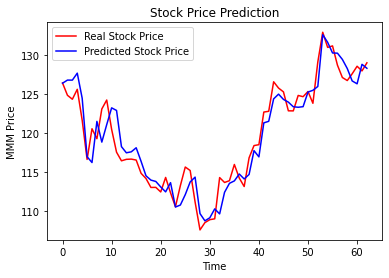

y_test_ori.shape (63, 1)
Epoch 1/500
3/3 [==============================] - 8s 55ms/step - loss: 0.4613
Epoch 2/500
3/3 [==============================] - 0s 62ms/step - loss: 0.3772
Epoch 3/500
3/3 [==============================] - 0s 50ms/step - loss: 0.2919
Epoch 4/500
3/3 [==============================] - 0s 55ms/step - loss: 0.2166
Epoch 5/500
3/3 [==============================] - 0s 53ms/step - loss: 0.2024
Epoch 6/500
3/3 [==============================] - 0s 66ms/step - loss: 0.2102
Epoch 7/500
3/3 [==============================] - 0s 66ms/step - loss: 0.1839
Epoch 8/500
3/3 [==============================] - 0s 60ms/step - loss: 0.1734
Epoch 9/500
3/3 [==============================] - 0s 61ms/step - loss: 0.1735
Epoch 10/500
3/3 [==============================] - 0s 54ms/step - loss: 0.1696
Epoch 11/500
3/3 [==============================] - 0s 52ms/step - loss: 0.1618
Epoch 12/500
3/3 [==============================] - 0s 63ms/step - loss: 0.1553
Epoch 13/500
3/3 [======

3/3 [==============================] - 0s 72ms/step - loss: 0.0808
Epoch 104/500
3/3 [==============================] - 0s 53ms/step - loss: 0.0812
Epoch 105/500
3/3 [==============================] - 0s 52ms/step - loss: 0.0810
Epoch 106/500
3/3 [==============================] - 0s 55ms/step - loss: 0.0807
Epoch 107/500
3/3 [==============================] - 0s 65ms/step - loss: 0.0807
Epoch 108/500
3/3 [==============================] - 0s 61ms/step - loss: 0.0807
Epoch 109/500
3/3 [==============================] - 0s 60ms/step - loss: 0.0809
Epoch 110/500
3/3 [==============================] - 0s 55ms/step - loss: 0.0805
Epoch 111/500
3/3 [==============================] - 0s 54ms/step - loss: 0.0813
Epoch 112/500
3/3 [==============================] - 0s 54ms/step - loss: 0.0810
Epoch 113/500
3/3 [==============================] - 0s 56ms/step - loss: 0.0812
Epoch 114/500
3/3 [==============================] - 0s 60ms/step - loss: 0.0811
Epoch 115/500
3/3 [=======================

3/3 [==============================] - 0s 49ms/step - loss: 0.0645
Epoch 306/500
3/3 [==============================] - 0s 55ms/step - loss: 0.0649
Epoch 307/500
3/3 [==============================] - 0s 57ms/step - loss: 0.0643
Epoch 308/500
3/3 [==============================] - 0s 54ms/step - loss: 0.0647
Epoch 309/500
3/3 [==============================] - 0s 55ms/step - loss: 0.0644
Epoch 310/500
3/3 [==============================] - 0s 55ms/step - loss: 0.0642
Epoch 311/500
3/3 [==============================] - 0s 50ms/step - loss: 0.0643
Epoch 312/500
3/3 [==============================] - 0s 58ms/step - loss: 0.0641
Epoch 313/500
3/3 [==============================] - 0s 54ms/step - loss: 0.0646
Epoch 314/500
3/3 [==============================] - 0s 61ms/step - loss: 0.0643
Epoch 315/500
3/3 [==============================] - 0s 55ms/step - loss: 0.0641
Epoch 316/500
3/3 [==============================] - 0s 54ms/step - loss: 0.0640
Epoch 317/500
3/3 [=======================

1/1 [==============================] - 0s 26ms/step
MSE [2.56996633]
accuracy [0.98782543]
mean_error_percent [0.01217457]


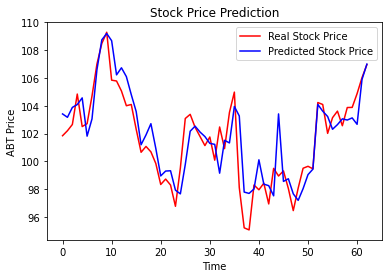

y_test_ori.shape (63, 1)
Epoch 1/500
3/3 [==============================] - 7s 50ms/step - loss: 0.4359
Epoch 2/500
3/3 [==============================] - 0s 57ms/step - loss: 0.3476
Epoch 3/500
3/3 [==============================] - 0s 57ms/step - loss: 0.2626
Epoch 4/500
3/3 [==============================] - 0s 60ms/step - loss: 0.2182
Epoch 5/500
3/3 [==============================] - 0s 60ms/step - loss: 0.2223
Epoch 6/500
3/3 [==============================] - 0s 60ms/step - loss: 0.2020
Epoch 7/500
3/3 [==============================] - 0s 61ms/step - loss: 0.1870
Epoch 8/500
3/3 [==============================] - 0s 65ms/step - loss: 0.1827
Epoch 9/500
3/3 [==============================] - 0s 60ms/step - loss: 0.1780
Epoch 10/500
3/3 [==============================] - 0s 55ms/step - loss: 0.1712
Epoch 11/500
3/3 [==============================] - 0s 60ms/step - loss: 0.1649
Epoch 12/500
3/3 [==============================] - 0s 56ms/step - loss: 0.1609
Epoch 13/500
3/3 [======

3/3 [==============================] - 0s 56ms/step - loss: 0.0775
Epoch 104/500
3/3 [==============================] - 0s 57ms/step - loss: 0.0776
Epoch 105/500
3/3 [==============================] - 0s 65ms/step - loss: 0.0785
Epoch 106/500
3/3 [==============================] - 0s 71ms/step - loss: 0.0774
Epoch 107/500
3/3 [==============================] - 0s 60ms/step - loss: 0.0785
Epoch 108/500
3/3 [==============================] - 0s 64ms/step - loss: 0.0782
Epoch 109/500
3/3 [==============================] - 0s 60ms/step - loss: 0.0776
Epoch 110/500
3/3 [==============================] - 0s 55ms/step - loss: 0.0780
Epoch 111/500
3/3 [==============================] - 0s 57ms/step - loss: 0.0778
Epoch 112/500
3/3 [==============================] - 0s 70ms/step - loss: 0.0776
Epoch 113/500
3/3 [==============================] - 0s 65ms/step - loss: 0.0779
Epoch 114/500
3/3 [==============================] - 0s 74ms/step - loss: 0.0777
Epoch 115/500
3/3 [=======================

3/3 [==============================] - 0s 60ms/step - loss: 0.0570
Epoch 306/500
3/3 [==============================] - 0s 61ms/step - loss: 0.0566
Epoch 307/500
3/3 [==============================] - 0s 52ms/step - loss: 0.0580
Epoch 308/500
3/3 [==============================] - 0s 65ms/step - loss: 0.0577
Epoch 309/500
3/3 [==============================] - 0s 53ms/step - loss: 0.0574
Epoch 310/500
3/3 [==============================] - 0s 55ms/step - loss: 0.0573
Epoch 311/500
3/3 [==============================] - 0s 52ms/step - loss: 0.0570
Epoch 312/500
3/3 [==============================] - 0s 52ms/step - loss: 0.0567
Epoch 313/500
3/3 [==============================] - 0s 55ms/step - loss: 0.0567
Epoch 314/500
3/3 [==============================] - 0s 56ms/step - loss: 0.0570
Epoch 315/500
3/3 [==============================] - 0s 54ms/step - loss: 0.0564
Epoch 316/500
3/3 [==============================] - 0s 60ms/step - loss: 0.0564
Epoch 317/500
3/3 [=======================

1/1 [==============================] - 0s 20ms/step
MSE [3.85738159]
accuracy [0.99004513]
mean_error_percent [0.00995487]


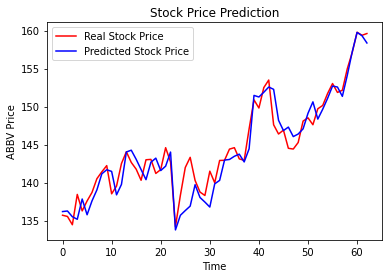

y_test_ori.shape (63, 1)
Epoch 1/500
3/3 [==============================] - 7s 50ms/step - loss: 0.4970
Epoch 2/500
3/3 [==============================] - 0s 48ms/step - loss: 0.3873
Epoch 3/500
3/3 [==============================] - 0s 55ms/step - loss: 0.2795
Epoch 4/500
3/3 [==============================] - 0s 50ms/step - loss: 0.2038
Epoch 5/500
3/3 [==============================] - 0s 53ms/step - loss: 0.2261
Epoch 6/500
3/3 [==============================] - 0s 59ms/step - loss: 0.2066
Epoch 7/500
3/3 [==============================] - 0s 57ms/step - loss: 0.1785
Epoch 8/500
3/3 [==============================] - 0s 55ms/step - loss: 0.1748
Epoch 9/500
3/3 [==============================] - 0s 51ms/step - loss: 0.1727
Epoch 10/500
3/3 [==============================] - 0s 55ms/step - loss: 0.1649
Epoch 11/500
3/3 [==============================] - 0s 55ms/step - loss: 0.1560
Epoch 12/500
3/3 [==============================] - 0s 55ms/step - loss: 0.1523
Epoch 13/500
3/3 [======

3/3 [==============================] - 0s 51ms/step - loss: 0.0712
Epoch 104/500
3/3 [==============================] - 0s 50ms/step - loss: 0.0710
Epoch 105/500
3/3 [==============================] - 0s 52ms/step - loss: 0.0711
Epoch 106/500
3/3 [==============================] - 0s 50ms/step - loss: 0.0708
Epoch 107/500
3/3 [==============================] - 0s 52ms/step - loss: 0.0712
Epoch 108/500
3/3 [==============================] - 0s 56ms/step - loss: 0.0711
Epoch 109/500
3/3 [==============================] - 0s 55ms/step - loss: 0.0710
Epoch 110/500
3/3 [==============================] - 0s 56ms/step - loss: 0.0712
Epoch 111/500
3/3 [==============================] - 0s 56ms/step - loss: 0.0709
Epoch 112/500
3/3 [==============================] - 0s 54ms/step - loss: 0.0709
Epoch 113/500
3/3 [==============================] - 0s 55ms/step - loss: 0.0708
Epoch 114/500
3/3 [==============================] - 0s 51ms/step - loss: 0.0709
Epoch 115/500
3/3 [=======================

3/3 [==============================] - 0s 52ms/step - loss: 0.0604
Epoch 306/500
3/3 [==============================] - 0s 60ms/step - loss: 0.0589
Epoch 307/500
3/3 [==============================] - 0s 50ms/step - loss: 0.0589
Epoch 308/500
3/3 [==============================] - 0s 60ms/step - loss: 0.0586
Epoch 309/500
3/3 [==============================] - 0s 50ms/step - loss: 0.0588
Epoch 310/500
3/3 [==============================] - 0s 48ms/step - loss: 0.0586
Epoch 311/500
3/3 [==============================] - 0s 51ms/step - loss: 0.0585
Epoch 312/500
3/3 [==============================] - 0s 52ms/step - loss: 0.0587
Epoch 313/500
3/3 [==============================] - 0s 53ms/step - loss: 0.0586
Epoch 314/500
3/3 [==============================] - 0s 50ms/step - loss: 0.0583
Epoch 315/500
3/3 [==============================] - 0s 53ms/step - loss: 0.0582
Epoch 316/500
3/3 [==============================] - 0s 50ms/step - loss: 0.0584
Epoch 317/500
3/3 [=======================

1/1 [==============================] - 0s 20ms/step
MSE [38.05997867]
accuracy [0.98216165]
mean_error_percent [0.01783835]


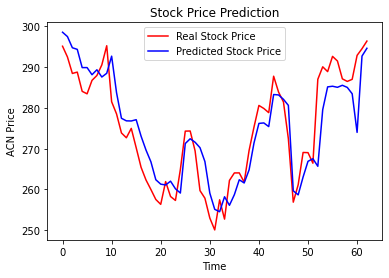

y_test_ori.shape (63, 1)
Epoch 1/500
3/3 [==============================] - 7s 60ms/step - loss: 0.4038
Epoch 2/500
3/3 [==============================] - 0s 60ms/step - loss: 0.3172
Epoch 3/500
3/3 [==============================] - 0s 59ms/step - loss: 0.2337
Epoch 4/500
3/3 [==============================] - 0s 62ms/step - loss: 0.2079
Epoch 5/500
3/3 [==============================] - 0s 62ms/step - loss: 0.2142
Epoch 6/500
3/3 [==============================] - 0s 58ms/step - loss: 0.1888
Epoch 7/500
3/3 [==============================] - 0s 61ms/step - loss: 0.1789
Epoch 8/500
3/3 [==============================] - 0s 60ms/step - loss: 0.1771
Epoch 9/500
3/3 [==============================] - 0s 66ms/step - loss: 0.1716
Epoch 10/500
3/3 [==============================] - 0s 62ms/step - loss: 0.1638
Epoch 11/500
3/3 [==============================] - 0s 66ms/step - loss: 0.1591
Epoch 12/500
3/3 [==============================] - 0s 64ms/step - loss: 0.1561
Epoch 13/500
3/3 [======

3/3 [==============================] - 0s 60ms/step - loss: 0.0791
Epoch 104/500
3/3 [==============================] - 0s 60ms/step - loss: 0.0788
Epoch 105/500
3/3 [==============================] - 0s 55ms/step - loss: 0.0789
Epoch 106/500
3/3 [==============================] - 0s 62ms/step - loss: 0.0788
Epoch 107/500
3/3 [==============================] - 0s 59ms/step - loss: 0.0790
Epoch 108/500
3/3 [==============================] - 0s 70ms/step - loss: 0.0788
Epoch 109/500
3/3 [==============================] - 0s 64ms/step - loss: 0.0787
Epoch 110/500
3/3 [==============================] - 0s 65ms/step - loss: 0.0789
Epoch 111/500
3/3 [==============================] - 0s 67ms/step - loss: 0.0787
Epoch 112/500
3/3 [==============================] - 0s 60ms/step - loss: 0.0790
Epoch 113/500
3/3 [==============================] - 0s 67ms/step - loss: 0.0788
Epoch 114/500
3/3 [==============================] - 0s 60ms/step - loss: 0.0793
Epoch 115/500
3/3 [=======================

3/3 [==============================] - 0s 69ms/step - loss: 0.0632
Epoch 306/500
3/3 [==============================] - 0s 64ms/step - loss: 0.0631
Epoch 307/500
3/3 [==============================] - 0s 67ms/step - loss: 0.0631
Epoch 308/500
3/3 [==============================] - 0s 62ms/step - loss: 0.0636
Epoch 309/500
3/3 [==============================] - 0s 67ms/step - loss: 0.0630
Epoch 310/500
3/3 [==============================] - 0s 62ms/step - loss: 0.0630
Epoch 311/500
3/3 [==============================] - 0s 65ms/step - loss: 0.0630
Epoch 312/500
3/3 [==============================] - 0s 75ms/step - loss: 0.0628
Epoch 313/500
3/3 [==============================] - 0s 65ms/step - loss: 0.0629
Epoch 314/500
3/3 [==============================] - 0s 71ms/step - loss: 0.0628
Epoch 315/500
3/3 [==============================] - 0s 74ms/step - loss: 0.0628
Epoch 316/500
3/3 [==============================] - 0s 72ms/step - loss: 0.0627
Epoch 317/500
3/3 [=======================

1/1 [==============================] - 0s 22ms/step
MSE [0.5535087]
accuracy [0.99256988]
mean_error_percent [0.00743012]


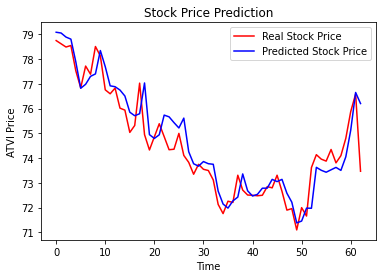

y_test_ori.shape (63, 1)
Epoch 1/500
3/3 [==============================] - 7s 60ms/step - loss: 0.4874
Epoch 2/500
3/3 [==============================] - 0s 57ms/step - loss: 0.3943
Epoch 3/500
3/3 [==============================] - 0s 59ms/step - loss: 0.3073
Epoch 4/500
3/3 [==============================] - 0s 60ms/step - loss: 0.2311
Epoch 5/500
3/3 [==============================] - 0s 59ms/step - loss: 0.2135
Epoch 6/500
3/3 [==============================] - 0s 60ms/step - loss: 0.2223
Epoch 7/500
3/3 [==============================] - 0s 67ms/step - loss: 0.1956
Epoch 8/500
3/3 [==============================] - 0s 64ms/step - loss: 0.1816
Epoch 9/500
3/3 [==============================] - 0s 61ms/step - loss: 0.1804
Epoch 10/500
3/3 [==============================] - 0s 58ms/step - loss: 0.1764
Epoch 11/500
3/3 [==============================] - 0s 65ms/step - loss: 0.1697
Epoch 12/500
3/3 [==============================] - 0s 60ms/step - loss: 0.1628
Epoch 13/500
3/3 [======

3/3 [==============================] - 0s 63ms/step - loss: 0.0738
Epoch 104/500
3/3 [==============================] - 0s 67ms/step - loss: 0.0732
Epoch 105/500
3/3 [==============================] - 0s 74ms/step - loss: 0.0737
Epoch 106/500
3/3 [==============================] - 0s 68ms/step - loss: 0.0732
Epoch 107/500
3/3 [==============================] - 0s 71ms/step - loss: 0.0732
Epoch 108/500
3/3 [==============================] - 0s 71ms/step - loss: 0.0737
Epoch 109/500
3/3 [==============================] - 0s 65ms/step - loss: 0.0734
Epoch 110/500
3/3 [==============================] - 0s 62ms/step - loss: 0.0736
Epoch 111/500
3/3 [==============================] - 0s 65ms/step - loss: 0.0735
Epoch 112/500
3/3 [==============================] - 0s 60ms/step - loss: 0.0734
Epoch 113/500
3/3 [==============================] - 0s 68ms/step - loss: 0.0734
Epoch 114/500
3/3 [==============================] - 0s 61ms/step - loss: 0.0732
Epoch 115/500
3/3 [=======================

3/3 [==============================] - 0s 56ms/step - loss: 0.0585
Epoch 306/500
3/3 [==============================] - 0s 56ms/step - loss: 0.0583
Epoch 307/500
3/3 [==============================] - 0s 60ms/step - loss: 0.0584
Epoch 308/500
3/3 [==============================] - 0s 63ms/step - loss: 0.0581
Epoch 309/500
3/3 [==============================] - 0s 66ms/step - loss: 0.0581
Epoch 310/500
3/3 [==============================] - 0s 67ms/step - loss: 0.0578
Epoch 311/500
3/3 [==============================] - 0s 66ms/step - loss: 0.0579
Epoch 312/500
3/3 [==============================] - 0s 66ms/step - loss: 0.0576
Epoch 313/500
3/3 [==============================] - 0s 60ms/step - loss: 0.0580
Epoch 314/500
3/3 [==============================] - 0s 60ms/step - loss: 0.0576
Epoch 315/500
3/3 [==============================] - 0s 62ms/step - loss: 0.0575
Epoch 316/500
3/3 [==============================] - 0s 56ms/step - loss: 0.0576
Epoch 317/500
3/3 [=======================

1/1 [==============================] - 0s 21ms/step
MSE [2.23169617]
accuracy [0.98730045]
mean_error_percent [0.01269955]


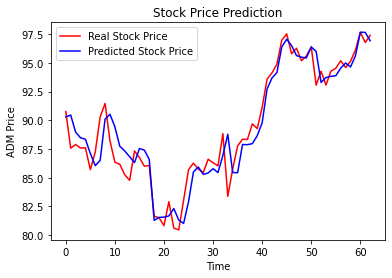

y_test_ori.shape (63, 1)
Epoch 1/500
3/3 [==============================] - 7s 59ms/step - loss: 0.4732
Epoch 2/500
3/3 [==============================] - 0s 57ms/step - loss: 0.3697
Epoch 3/500
3/3 [==============================] - 0s 60ms/step - loss: 0.2705
Epoch 4/500
3/3 [==============================] - 0s 64ms/step - loss: 0.2015
Epoch 5/500
3/3 [==============================] - 0s 68ms/step - loss: 0.2175
Epoch 6/500
3/3 [==============================] - 0s 73ms/step - loss: 0.1973
Epoch 7/500
3/3 [==============================] - 0s 61ms/step - loss: 0.1759
Epoch 8/500
3/3 [==============================] - 0s 68ms/step - loss: 0.1735
Epoch 9/500
3/3 [==============================] - 0s 62ms/step - loss: 0.1716
Epoch 10/500
3/3 [==============================] - 0s 67ms/step - loss: 0.1643
Epoch 11/500
3/3 [==============================] - 0s 63ms/step - loss: 0.1569
Epoch 12/500
3/3 [==============================] - 0s 61ms/step - loss: 0.1539
Epoch 13/500
3/3 [======

3/3 [==============================] - 0s 63ms/step - loss: 0.0820
Epoch 104/500
3/3 [==============================] - 0s 61ms/step - loss: 0.0816
Epoch 105/500
3/3 [==============================] - 0s 62ms/step - loss: 0.0816
Epoch 106/500
3/3 [==============================] - 0s 61ms/step - loss: 0.0821
Epoch 107/500
3/3 [==============================] - 0s 60ms/step - loss: 0.0813
Epoch 108/500
3/3 [==============================] - 0s 61ms/step - loss: 0.0820
Epoch 109/500
3/3 [==============================] - 0s 66ms/step - loss: 0.0816
Epoch 110/500
3/3 [==============================] - 0s 60ms/step - loss: 0.0814
Epoch 111/500
3/3 [==============================] - 0s 60ms/step - loss: 0.0812
Epoch 112/500
3/3 [==============================] - 0s 68ms/step - loss: 0.0815
Epoch 113/500
3/3 [==============================] - 0s 62ms/step - loss: 0.0813
Epoch 114/500
3/3 [==============================] - 0s 66ms/step - loss: 0.0819
Epoch 115/500
3/3 [=======================

3/3 [==============================] - 0s 61ms/step - loss: 0.0616
Epoch 306/500
3/3 [==============================] - 0s 60ms/step - loss: 0.0616
Epoch 307/500
3/3 [==============================] - 0s 59ms/step - loss: 0.0613
Epoch 308/500
3/3 [==============================] - 0s 61ms/step - loss: 0.0615
Epoch 309/500
3/3 [==============================] - 0s 57ms/step - loss: 0.0615
Epoch 310/500
3/3 [==============================] - 0s 62ms/step - loss: 0.0612
Epoch 311/500
3/3 [==============================] - 0s 60ms/step - loss: 0.0615
Epoch 312/500
3/3 [==============================] - 0s 60ms/step - loss: 0.0617
Epoch 313/500
3/3 [==============================] - 0s 68ms/step - loss: 0.0619
Epoch 314/500
3/3 [==============================] - 0s 60ms/step - loss: 0.0619
Epoch 315/500
3/3 [==============================] - 0s 65ms/step - loss: 0.0618
Epoch 316/500
3/3 [==============================] - 0s 61ms/step - loss: 0.0614
Epoch 317/500
3/3 [=======================

1/1 [==============================] - 0s 22ms/step
MSE [181.35737806]
accuracy [0.97124722]
mean_error_percent [0.02875278]


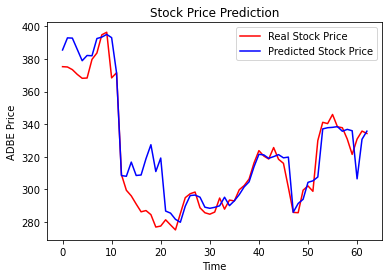

y_test_ori.shape (63, 1)
Epoch 1/500
3/3 [==============================] - 7s 60ms/step - loss: 0.4947
Epoch 2/500
3/3 [==============================] - 0s 62ms/step - loss: 0.3950
Epoch 3/500
3/3 [==============================] - 0s 63ms/step - loss: 0.2972
Epoch 4/500
3/3 [==============================] - 0s 65ms/step - loss: 0.2150
Epoch 5/500
3/3 [==============================] - 0s 68ms/step - loss: 0.2236
Epoch 6/500
3/3 [==============================] - 0s 67ms/step - loss: 0.2185
Epoch 7/500
3/3 [==============================] - 0s 67ms/step - loss: 0.1857
Epoch 8/500
3/3 [==============================] - 0s 64ms/step - loss: 0.1783
Epoch 9/500
3/3 [==============================] - 0s 66ms/step - loss: 0.1775
Epoch 10/500
3/3 [==============================] - 0s 71ms/step - loss: 0.1715
Epoch 11/500
3/3 [==============================] - 0s 68ms/step - loss: 0.1620
Epoch 12/500
3/3 [==============================] - 0s 68ms/step - loss: 0.1545
Epoch 13/500
3/3 [======

3/3 [==============================] - 0s 66ms/step - loss: 0.0765
Epoch 104/500
3/3 [==============================] - 0s 66ms/step - loss: 0.0760
Epoch 105/500
3/3 [==============================] - 0s 65ms/step - loss: 0.0759
Epoch 106/500
3/3 [==============================] - 0s 68ms/step - loss: 0.0759
Epoch 107/500
3/3 [==============================] - 0s 65ms/step - loss: 0.0759
Epoch 108/500
3/3 [==============================] - 0s 67ms/step - loss: 0.0759
Epoch 109/500
3/3 [==============================] - 0s 64ms/step - loss: 0.0760
Epoch 110/500
3/3 [==============================] - 0s 64ms/step - loss: 0.0762
Epoch 111/500
3/3 [==============================] - 0s 62ms/step - loss: 0.0757
Epoch 112/500
3/3 [==============================] - 0s 64ms/step - loss: 0.0760
Epoch 113/500
3/3 [==============================] - 0s 66ms/step - loss: 0.0760
Epoch 114/500
3/3 [==============================] - 0s 68ms/step - loss: 0.0756
Epoch 115/500
3/3 [=======================

3/3 [==============================] - 0s 69ms/step - loss: 0.0580
Epoch 306/500
3/3 [==============================] - 0s 67ms/step - loss: 0.0582
Epoch 307/500
3/3 [==============================] - 0s 70ms/step - loss: 0.0580
Epoch 308/500
3/3 [==============================] - 0s 73ms/step - loss: 0.0582
Epoch 309/500
3/3 [==============================] - 0s 81ms/step - loss: 0.0580
Epoch 310/500
3/3 [==============================] - 0s 72ms/step - loss: 0.0579
Epoch 311/500
3/3 [==============================] - 0s 75ms/step - loss: 0.0579
Epoch 312/500
3/3 [==============================] - 0s 71ms/step - loss: 0.0578
Epoch 313/500
3/3 [==============================] - 0s 72ms/step - loss: 0.0576
Epoch 314/500
3/3 [==============================] - 0s 72ms/step - loss: 0.0580
Epoch 315/500
3/3 [==============================] - 0s 68ms/step - loss: 0.0579
Epoch 316/500
3/3 [==============================] - 0s 73ms/step - loss: 0.0578
Epoch 317/500
3/3 [=======================

1/1 [==============================] - 0s 22ms/step
MSE [8.99961792]
accuracy [0.98921293]
mean_error_percent [0.01078707]


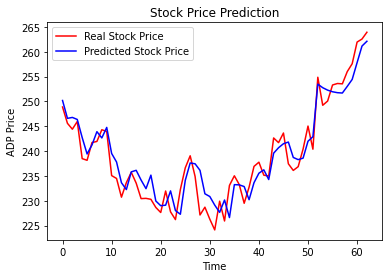

y_test_ori.shape (63, 1)
Epoch 1/500
3/3 [==============================] - 7s 70ms/step - loss: 0.4815
Epoch 2/500
3/3 [==============================] - 0s 71ms/step - loss: 0.3851
Epoch 3/500
3/3 [==============================] - 0s 72ms/step - loss: 0.2848
Epoch 4/500
3/3 [==============================] - 0s 70ms/step - loss: 0.2114
Epoch 5/500
3/3 [==============================] - 0s 69ms/step - loss: 0.2263
Epoch 6/500
3/3 [==============================] - 0s 71ms/step - loss: 0.2071
Epoch 7/500
3/3 [==============================] - 0s 72ms/step - loss: 0.1829
Epoch 8/500
3/3 [==============================] - 0s 76ms/step - loss: 0.1802
Epoch 9/500
3/3 [==============================] - 0s 71ms/step - loss: 0.1784
Epoch 10/500
3/3 [==============================] - 0s 76ms/step - loss: 0.1693
Epoch 11/500
3/3 [==============================] - 0s 71ms/step - loss: 0.1606
Epoch 12/500
3/3 [==============================] - 0s 67ms/step - loss: 0.1580
Epoch 13/500
3/3 [======

3/3 [==============================] - 0s 65ms/step - loss: 0.0704
Epoch 104/500
3/3 [==============================] - 0s 67ms/step - loss: 0.0703
Epoch 105/500
3/3 [==============================] - 0s 71ms/step - loss: 0.0705
Epoch 106/500
3/3 [==============================] - 0s 69ms/step - loss: 0.0699
Epoch 107/500
3/3 [==============================] - 0s 60ms/step - loss: 0.0707
Epoch 108/500
3/3 [==============================] - 0s 61ms/step - loss: 0.0703
Epoch 109/500
3/3 [==============================] - 0s 72ms/step - loss: 0.0703
Epoch 110/500
3/3 [==============================] - 0s 67ms/step - loss: 0.0702
Epoch 111/500
3/3 [==============================] - 0s 67ms/step - loss: 0.0707
Epoch 112/500
3/3 [==============================] - 0s 67ms/step - loss: 0.0702
Epoch 113/500
3/3 [==============================] - 0s 65ms/step - loss: 0.0704
Epoch 114/500
3/3 [==============================] - 0s 65ms/step - loss: 0.0701
Epoch 115/500
3/3 [=======================

3/3 [==============================] - 0s 74ms/step - loss: 0.0520
Epoch 306/500
3/3 [==============================] - 0s 69ms/step - loss: 0.0523
Epoch 307/500
3/3 [==============================] - 0s 67ms/step - loss: 0.0515
Epoch 308/500
3/3 [==============================] - 0s 70ms/step - loss: 0.0527
Epoch 309/500
3/3 [==============================] - 0s 66ms/step - loss: 0.0516
Epoch 310/500
3/3 [==============================] - 0s 70ms/step - loss: 0.0519
Epoch 311/500
3/3 [==============================] - 0s 72ms/step - loss: 0.0517
Epoch 312/500
3/3 [==============================] - 0s 68ms/step - loss: 0.0515
Epoch 313/500
3/3 [==============================] - 0s 65ms/step - loss: 0.0513
Epoch 314/500
3/3 [==============================] - 0s 76ms/step - loss: 0.0514
Epoch 315/500
3/3 [==============================] - 0s 73ms/step - loss: 0.0515
Epoch 316/500
3/3 [==============================] - 0s 74ms/step - loss: 0.0520
Epoch 317/500
3/3 [=======================

1/1 [==============================] - 0s 21ms/step
MSE [6.77591118]
accuracy [0.98458548]
mean_error_percent [0.01541452]


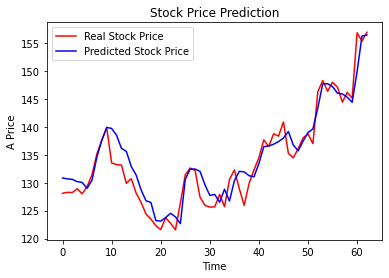

y_test_ori.shape (63, 1)
Epoch 1/500
3/3 [==============================] - 7s 63ms/step - loss: 0.4585
Epoch 2/500
3/3 [==============================] - 0s 64ms/step - loss: 0.3572
Epoch 3/500
3/3 [==============================] - 0s 66ms/step - loss: 0.2649
Epoch 4/500
3/3 [==============================] - 0s 66ms/step - loss: 0.2025
Epoch 5/500
3/3 [==============================] - 0s 67ms/step - loss: 0.2162
Epoch 6/500
3/3 [==============================] - 0s 73ms/step - loss: 0.1996
Epoch 7/500
3/3 [==============================] - 0s 69ms/step - loss: 0.1768
Epoch 8/500
3/3 [==============================] - 0s 68ms/step - loss: 0.1744
Epoch 9/500
3/3 [==============================] - 0s 65ms/step - loss: 0.1726
Epoch 10/500
3/3 [==============================] - 0s 66ms/step - loss: 0.1652
Epoch 11/500
3/3 [==============================] - 0s 71ms/step - loss: 0.1573
Epoch 12/500
3/3 [==============================] - 0s 71ms/step - loss: 0.1523
Epoch 13/500
3/3 [======

3/3 [==============================] - 0s 69ms/step - loss: 0.0745
Epoch 104/500
3/3 [==============================] - 0s 60ms/step - loss: 0.0745
Epoch 105/500
3/3 [==============================] - 0s 64ms/step - loss: 0.0744
Epoch 106/500
3/3 [==============================] - 0s 60ms/step - loss: 0.0743
Epoch 107/500
3/3 [==============================] - 0s 70ms/step - loss: 0.0744
Epoch 108/500
3/3 [==============================] - 0s 72ms/step - loss: 0.0744
Epoch 109/500
3/3 [==============================] - 0s 73ms/step - loss: 0.0748
Epoch 110/500
3/3 [==============================] - 0s 70ms/step - loss: 0.0745
Epoch 111/500
3/3 [==============================] - 0s 87ms/step - loss: 0.0744
Epoch 112/500
3/3 [==============================] - 0s 82ms/step - loss: 0.0744
Epoch 113/500
3/3 [==============================] - 0s 77ms/step - loss: 0.0743
Epoch 114/500
3/3 [==============================] - 0s 67ms/step - loss: 0.0745
Epoch 115/500
3/3 [=======================

3/3 [==============================] - 0s 69ms/step - loss: 0.0567
Epoch 306/500
3/3 [==============================] - 0s 69ms/step - loss: 0.0567
Epoch 307/500
3/3 [==============================] - 0s 66ms/step - loss: 0.0573
Epoch 308/500
3/3 [==============================] - 0s 71ms/step - loss: 0.0567
Epoch 309/500
3/3 [==============================] - 0s 71ms/step - loss: 0.0567
Epoch 310/500
3/3 [==============================] - 0s 69ms/step - loss: 0.0564
Epoch 311/500
3/3 [==============================] - 0s 67ms/step - loss: 0.0563
Epoch 312/500
3/3 [==============================] - 0s 64ms/step - loss: 0.0567
Epoch 313/500
3/3 [==============================] - 0s 68ms/step - loss: 0.0565
Epoch 314/500
3/3 [==============================] - 0s 69ms/step - loss: 0.0571
Epoch 315/500
3/3 [==============================] - 0s 69ms/step - loss: 0.0558
Epoch 316/500
3/3 [==============================] - 0s 67ms/step - loss: 0.0567
Epoch 317/500
3/3 [=======================

1/1 [==============================] - 0s 23ms/step
MSE [2.66017221]
accuracy [0.98451979]
mean_error_percent [0.01548021]


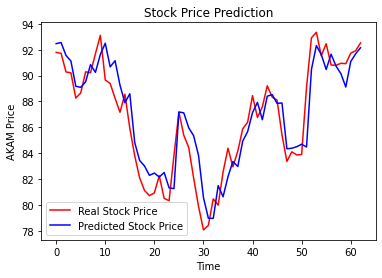

y_test_ori.shape (63, 1)
Epoch 1/500
3/3 [==============================] - 7s 67ms/step - loss: 0.3824
Epoch 2/500
3/3 [==============================] - 0s 65ms/step - loss: 0.2973
Epoch 3/500
3/3 [==============================] - 0s 65ms/step - loss: 0.2244
Epoch 4/500
3/3 [==============================] - 0s 71ms/step - loss: 0.2019
Epoch 5/500
3/3 [==============================] - 0s 65ms/step - loss: 0.2067
Epoch 6/500
3/3 [==============================] - 0s 80ms/step - loss: 0.1857
Epoch 7/500
3/3 [==============================] - 0s 80ms/step - loss: 0.1777
Epoch 8/500
3/3 [==============================] - 0s 72ms/step - loss: 0.1769
Epoch 9/500
3/3 [==============================] - 0s 68ms/step - loss: 0.1722
Epoch 10/500
3/3 [==============================] - 0s 65ms/step - loss: 0.1650
Epoch 11/500
3/3 [==============================] - 0s 67ms/step - loss: 0.1611
Epoch 12/500
3/3 [==============================] - 0s 66ms/step - loss: 0.1592
Epoch 13/500
3/3 [======

3/3 [==============================] - 0s 73ms/step - loss: 0.0825
Epoch 104/500
3/3 [==============================] - 0s 70ms/step - loss: 0.0824
Epoch 105/500
3/3 [==============================] - 0s 68ms/step - loss: 0.0822
Epoch 106/500
3/3 [==============================] - 0s 85ms/step - loss: 0.0823
Epoch 107/500
3/3 [==============================] - 0s 100ms/step - loss: 0.0821
Epoch 108/500
3/3 [==============================] - 0s 75ms/step - loss: 0.0821
Epoch 109/500
3/3 [==============================] - 0s 70ms/step - loss: 0.0820
Epoch 110/500
3/3 [==============================] - 0s 71ms/step - loss: 0.0823
Epoch 111/500
3/3 [==============================] - 0s 71ms/step - loss: 0.0816
Epoch 112/500
3/3 [==============================] - 0s 66ms/step - loss: 0.0826
Epoch 113/500
3/3 [==============================] - 0s 70ms/step - loss: 0.0825
Epoch 114/500
3/3 [==============================] - 0s 70ms/step - loss: 0.0820
Epoch 115/500
3/3 [======================

3/3 [==============================] - 0s 71ms/step - loss: 0.0614
Epoch 306/500
3/3 [==============================] - 0s 74ms/step - loss: 0.0611
Epoch 307/500
3/3 [==============================] - 0s 74ms/step - loss: 0.0613
Epoch 308/500
3/3 [==============================] - 0s 70ms/step - loss: 0.0612
Epoch 309/500
3/3 [==============================] - 0s 73ms/step - loss: 0.0612
Epoch 310/500
3/3 [==============================] - 0s 77ms/step - loss: 0.0610
Epoch 311/500
3/3 [==============================] - 0s 72ms/step - loss: 0.0614
Epoch 312/500
3/3 [==============================] - 0s 77ms/step - loss: 0.0608
Epoch 313/500
3/3 [==============================] - 0s 74ms/step - loss: 0.0611
Epoch 314/500
3/3 [==============================] - 0s 71ms/step - loss: 0.0610
Epoch 315/500
3/3 [==============================] - 0s 72ms/step - loss: 0.0609
Epoch 316/500
3/3 [==============================] - 0s 70ms/step - loss: 0.0610
Epoch 317/500
3/3 [=======================

1/1 [==============================] - 0s 20ms/step
MSE [0.55047889]
accuracy [0.98632965]
mean_error_percent [0.01367035]


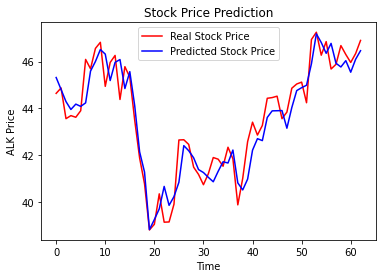

y_test_ori.shape (63, 1)
Epoch 1/500
3/3 [==============================] - 7s 70ms/step - loss: 0.4062
Epoch 2/500
3/3 [==============================] - 0s 70ms/step - loss: 0.3052
Epoch 3/500
3/3 [==============================] - 0s 93ms/step - loss: 0.2280
Epoch 4/500
3/3 [==============================] - 0s 82ms/step - loss: 0.2149
Epoch 5/500
3/3 [==============================] - 0s 76ms/step - loss: 0.2139
Epoch 6/500
3/3 [==============================] - 0s 73ms/step - loss: 0.1912
Epoch 7/500
3/3 [==============================] - 0s 76ms/step - loss: 0.1827
Epoch 8/500
3/3 [==============================] - 0s 83ms/step - loss: 0.1817
Epoch 9/500
3/3 [==============================] - 0s 73ms/step - loss: 0.1775
Epoch 10/500
3/3 [==============================] - 0s 73ms/step - loss: 0.1702
Epoch 11/500
3/3 [==============================] - 0s 76ms/step - loss: 0.1639
Epoch 12/500
3/3 [==============================] - 0s 73ms/step - loss: 0.1621
Epoch 13/500
3/3 [======

3/3 [==============================] - 0s 76ms/step - loss: 0.0856
Epoch 104/500
3/3 [==============================] - 0s 70ms/step - loss: 0.0857
Epoch 105/500
3/3 [==============================] - 0s 73ms/step - loss: 0.0849
Epoch 106/500
3/3 [==============================] - 0s 71ms/step - loss: 0.0856
Epoch 107/500
3/3 [==============================] - 0s 70ms/step - loss: 0.0862
Epoch 108/500
3/3 [==============================] - 0s 76ms/step - loss: 0.0852
Epoch 109/500
3/3 [==============================] - 0s 71ms/step - loss: 0.0852
Epoch 110/500
3/3 [==============================] - 0s 73ms/step - loss: 0.0861
Epoch 111/500
3/3 [==============================] - 0s 72ms/step - loss: 0.0872
Epoch 112/500
3/3 [==============================] - 0s 72ms/step - loss: 0.0851
Epoch 113/500
3/3 [==============================] - 0s 74ms/step - loss: 0.0860
Epoch 114/500
3/3 [==============================] - 0s 72ms/step - loss: 0.0856
Epoch 115/500
3/3 [=======================

3/3 [==============================] - 0s 76ms/step - loss: 0.0633
Epoch 306/500
3/3 [==============================] - 0s 75ms/step - loss: 0.0645
Epoch 307/500
3/3 [==============================] - 0s 72ms/step - loss: 0.0634
Epoch 308/500
3/3 [==============================] - 0s 74ms/step - loss: 0.0631
Epoch 309/500
3/3 [==============================] - 0s 72ms/step - loss: 0.0633
Epoch 310/500
3/3 [==============================] - 0s 77ms/step - loss: 0.0630
Epoch 311/500
3/3 [==============================] - 0s 76ms/step - loss: 0.0629
Epoch 312/500
3/3 [==============================] - 0s 74ms/step - loss: 0.0630
Epoch 313/500
3/3 [==============================] - 0s 72ms/step - loss: 0.0630
Epoch 314/500
3/3 [==============================] - 0s 71ms/step - loss: 0.0629
Epoch 315/500
3/3 [==============================] - 0s 75ms/step - loss: 0.0630
Epoch 316/500
3/3 [==============================] - 0s 78ms/step - loss: 0.0629
Epoch 317/500
3/3 [=======================

1/1 [==============================] - 0s 22ms/step
MSE [3.34231517]
accuracy [0.98428024]
mean_error_percent [0.01571976]


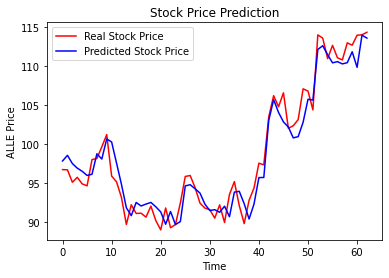

y_test_ori.shape (63, 1)
Epoch 1/500
3/3 [==============================] - 7s 70ms/step - loss: 0.4440
Epoch 2/500
3/3 [==============================] - 0s 76ms/step - loss: 0.3285
Epoch 3/500
3/3 [==============================] - 0s 80ms/step - loss: 0.2321
Epoch 4/500
3/3 [==============================] - 0s 77ms/step - loss: 0.2170
Epoch 5/500
3/3 [==============================] - 0s 76ms/step - loss: 0.2186
Epoch 6/500
3/3 [==============================] - 0s 79ms/step - loss: 0.1894
Epoch 7/500
3/3 [==============================] - 0s 75ms/step - loss: 0.1837
Epoch 8/500
3/3 [==============================] - 0s 72ms/step - loss: 0.1828
Epoch 9/500
3/3 [==============================] - 0s 74ms/step - loss: 0.1768
Epoch 10/500
3/3 [==============================] - 0s 71ms/step - loss: 0.1679
Epoch 11/500
3/3 [==============================] - 0s 77ms/step - loss: 0.1632
Epoch 12/500
3/3 [==============================] - 0s 74ms/step - loss: 0.1616
Epoch 13/500
3/3 [======

3/3 [==============================] - 0s 85ms/step - loss: 0.0890
Epoch 104/500
3/3 [==============================] - 0s 95ms/step - loss: 0.0889
Epoch 105/500
3/3 [==============================] - 0s 78ms/step - loss: 0.0887
Epoch 106/500
3/3 [==============================] - 0s 78ms/step - loss: 0.0888
Epoch 107/500
3/3 [==============================] - 0s 74ms/step - loss: 0.0894
Epoch 108/500
3/3 [==============================] - 0s 74ms/step - loss: 0.0896
Epoch 109/500
3/3 [==============================] - 0s 81ms/step - loss: 0.0887
Epoch 110/500
3/3 [==============================] - 0s 76ms/step - loss: 0.0898
Epoch 111/500
3/3 [==============================] - 0s 75ms/step - loss: 0.0888
Epoch 112/500
3/3 [==============================] - 0s 77ms/step - loss: 0.0894
Epoch 113/500
3/3 [==============================] - 0s 73ms/step - loss: 0.0887
Epoch 114/500
3/3 [==============================] - 0s 74ms/step - loss: 0.0887
Epoch 115/500
3/3 [=======================

3/3 [==============================] - 0s 75ms/step - loss: 0.0665
Epoch 306/500
3/3 [==============================] - 0s 72ms/step - loss: 0.0668
Epoch 307/500
3/3 [==============================] - 0s 93ms/step - loss: 0.0665
Epoch 308/500
3/3 [==============================] - 0s 80ms/step - loss: 0.0667
Epoch 309/500
3/3 [==============================] - 0s 74ms/step - loss: 0.0662
Epoch 310/500
3/3 [==============================] - 0s 72ms/step - loss: 0.0662
Epoch 311/500
3/3 [==============================] - 0s 72ms/step - loss: 0.0663
Epoch 312/500
3/3 [==============================] - 0s 77ms/step - loss: 0.0659
Epoch 313/500
3/3 [==============================] - 0s 77ms/step - loss: 0.0662
Epoch 314/500
3/3 [==============================] - 0s 79ms/step - loss: 0.0664
Epoch 315/500
3/3 [==============================] - 0s 79ms/step - loss: 0.0661
Epoch 316/500
3/3 [==============================] - 0s 75ms/step - loss: 0.0664
Epoch 317/500
3/3 [=======================

1/1 [==============================] - 0s 20ms/step
MSE [6.06360265]
accuracy [0.97976367]
mean_error_percent [0.02023633]


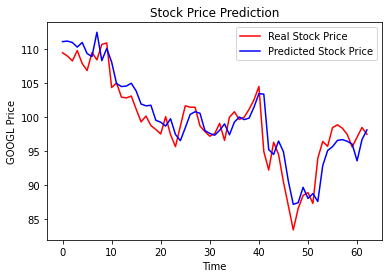

y_test_ori.shape (63, 1)
Epoch 1/500
3/3 [==============================] - 7s 70ms/step - loss: 0.4570
Epoch 2/500
3/3 [==============================] - 0s 71ms/step - loss: 0.3496
Epoch 3/500
3/3 [==============================] - 0s 72ms/step - loss: 0.2544
Epoch 4/500
3/3 [==============================] - 0s 71ms/step - loss: 0.2106
Epoch 5/500
3/3 [==============================] - 0s 70ms/step - loss: 0.2239
Epoch 6/500
3/3 [==============================] - 0s 80ms/step - loss: 0.1979
Epoch 7/500
3/3 [==============================] - 0s 80ms/step - loss: 0.1841
Epoch 8/500
3/3 [==============================] - 0s 71ms/step - loss: 0.1839
Epoch 9/500
3/3 [==============================] - 0s 77ms/step - loss: 0.1802
Epoch 10/500
3/3 [==============================] - 0s 76ms/step - loss: 0.1722
Epoch 11/500
3/3 [==============================] - 0s 71ms/step - loss: 0.1651
Epoch 12/500
3/3 [==============================] - 0s 73ms/step - loss: 0.1619
Epoch 13/500
3/3 [======

3/3 [==============================] - 0s 77ms/step - loss: 0.0881
Epoch 104/500
3/3 [==============================] - 0s 75ms/step - loss: 0.0881
Epoch 105/500
3/3 [==============================] - 0s 80ms/step - loss: 0.0881
Epoch 106/500
3/3 [==============================] - 0s 75ms/step - loss: 0.0882
Epoch 107/500
3/3 [==============================] - 0s 77ms/step - loss: 0.0878
Epoch 108/500
3/3 [==============================] - 0s 76ms/step - loss: 0.0878
Epoch 109/500
3/3 [==============================] - 0s 77ms/step - loss: 0.0877
Epoch 110/500
3/3 [==============================] - 0s 82ms/step - loss: 0.0878
Epoch 111/500
3/3 [==============================] - 0s 72ms/step - loss: 0.0877
Epoch 112/500
3/3 [==============================] - 0s 67ms/step - loss: 0.0877
Epoch 113/500
3/3 [==============================] - 0s 77ms/step - loss: 0.0878
Epoch 114/500
3/3 [==============================] - 0s 72ms/step - loss: 0.0881
Epoch 115/500
3/3 [=======================

3/3 [==============================] - 0s 84ms/step - loss: 0.0651
Epoch 306/500
3/3 [==============================] - 0s 93ms/step - loss: 0.0658
Epoch 307/500
3/3 [==============================] - 0s 78ms/step - loss: 0.0665
Epoch 308/500
3/3 [==============================] - 0s 86ms/step - loss: 0.0662
Epoch 309/500
3/3 [==============================] - 0s 73ms/step - loss: 0.0660
Epoch 310/500
3/3 [==============================] - 0s 73ms/step - loss: 0.0647
Epoch 311/500
3/3 [==============================] - 0s 75ms/step - loss: 0.0680
Epoch 312/500
3/3 [==============================] - 0s 83ms/step - loss: 0.0671
Epoch 313/500
3/3 [==============================] - 0s 79ms/step - loss: 0.0654
Epoch 314/500
3/3 [==============================] - 0s 78ms/step - loss: 0.0664
Epoch 315/500
3/3 [==============================] - 0s 73ms/step - loss: 0.0658
Epoch 316/500
3/3 [==============================] - 0s 75ms/step - loss: 0.0654
Epoch 317/500
3/3 [=======================

1/1 [==============================] - 0s 31ms/step
MSE [6.04707729]
accuracy [0.98094698]
mean_error_percent [0.01905302]


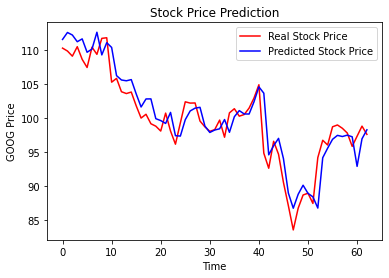

y_test_ori.shape (63, 1)
Epoch 1/500
3/3 [==============================] - 8s 76ms/step - loss: 0.4004
Epoch 2/500
3/3 [==============================] - 0s 78ms/step - loss: 0.3070
Epoch 3/500
3/3 [==============================] - 0s 79ms/step - loss: 0.2290
Epoch 4/500
3/3 [==============================] - 0s 84ms/step - loss: 0.2084
Epoch 5/500
3/3 [==============================] - 0s 84ms/step - loss: 0.2136
Epoch 6/500
3/3 [==============================] - 0s 92ms/step - loss: 0.1903
Epoch 7/500
3/3 [==============================] - 0s 82ms/step - loss: 0.1792
Epoch 8/500
3/3 [==============================] - 0s 76ms/step - loss: 0.1764
Epoch 9/500
3/3 [==============================] - 0s 85ms/step - loss: 0.1726
Epoch 10/500
3/3 [==============================] - 0s 94ms/step - loss: 0.1662
Epoch 11/500
3/3 [==============================] - 0s 93ms/step - loss: 0.1599
Epoch 12/500
3/3 [==============================] - 0s 77ms/step - loss: 0.1566
Epoch 13/500
3/3 [======

3/3 [==============================] - 0s 106ms/step - loss: 0.0761
Epoch 104/500
3/3 [==============================] - 0s 93ms/step - loss: 0.0760
Epoch 105/500
3/3 [==============================] - 0s 79ms/step - loss: 0.0756
Epoch 106/500
3/3 [==============================] - 0s 96ms/step - loss: 0.0761
Epoch 107/500
3/3 [==============================] - 0s 79ms/step - loss: 0.0762
Epoch 108/500
3/3 [==============================] - 0s 77ms/step - loss: 0.0755
Epoch 109/500
3/3 [==============================] - 0s 104ms/step - loss: 0.0762
Epoch 110/500
3/3 [==============================] - 0s 79ms/step - loss: 0.0760
Epoch 111/500
3/3 [==============================] - 0s 73ms/step - loss: 0.0754
Epoch 112/500
3/3 [==============================] - 0s 119ms/step - loss: 0.0756
Epoch 113/500
3/3 [==============================] - 0s 86ms/step - loss: 0.0751
Epoch 114/500
3/3 [==============================] - 0s 77ms/step - loss: 0.0751
Epoch 115/500
3/3 [====================

3/3 [==============================] - 0s 75ms/step - loss: 0.0649
Epoch 205/500
3/3 [==============================] - 0s 76ms/step - loss: 0.0640
Epoch 206/500
3/3 [==============================] - 0s 71ms/step - loss: 0.0641
Epoch 207/500
3/3 [==============================] - 0s 77ms/step - loss: 0.0645
Epoch 208/500
3/3 [==============================] - 0s 76ms/step - loss: 0.0661
Epoch 209/500
3/3 [==============================] - 0s 76ms/step - loss: 0.0651
Epoch 210/500
3/3 [==============================] - 0s 75ms/step - loss: 0.0649
Epoch 211/500
3/3 [==============================] - 0s 78ms/step - loss: 0.0651
Epoch 212/500
3/3 [==============================] - 0s 70ms/step - loss: 0.0637
Epoch 213/500
3/3 [==============================] - 0s 75ms/step - loss: 0.0652
Epoch 214/500
3/3 [==============================] - 0s 75ms/step - loss: 0.0645
Epoch 215/500
3/3 [==============================] - 0s 77ms/step - loss: 0.0646
Epoch 216/500
3/3 [=======================

3/3 [==============================] - 0s 76ms/step - loss: 0.0583
Epoch 407/500
3/3 [==============================] - 0s 75ms/step - loss: 0.0589
Epoch 408/500
3/3 [==============================] - 0s 78ms/step - loss: 0.0586
Epoch 409/500
3/3 [==============================] - 0s 75ms/step - loss: 0.0580
Epoch 410/500
3/3 [==============================] - 0s 72ms/step - loss: 0.0581
Epoch 411/500
3/3 [==============================] - 0s 80ms/step - loss: 0.0602
Epoch 412/500
3/3 [==============================] - 0s 81ms/step - loss: 0.0589
Epoch 413/500
3/3 [==============================] - 0s 75ms/step - loss: 0.0581
Epoch 414/500
3/3 [==============================] - 0s 72ms/step - loss: 0.0586
Epoch 415/500
3/3 [==============================] - 0s 70ms/step - loss: 0.0585
Epoch 416/500
3/3 [==============================] - 0s 73ms/step - loss: 0.0588
Epoch 417/500
3/3 [==============================] - 0s 77ms/step - loss: 0.0584
Epoch 418/500
3/3 [=======================

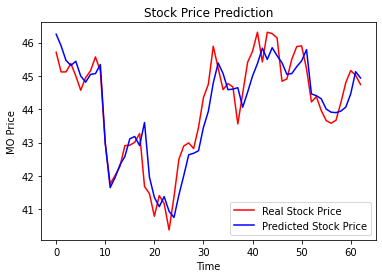

y_test_ori.shape (63, 1)
Epoch 1/500
3/3 [==============================] - 7s 77ms/step - loss: 0.3640
Epoch 2/500
3/3 [==============================] - 0s 84ms/step - loss: 0.2886
Epoch 3/500
3/3 [==============================] - 0s 86ms/step - loss: 0.2229
Epoch 4/500
3/3 [==============================] - 0s 88ms/step - loss: 0.1952
Epoch 5/500
3/3 [==============================] - 0s 82ms/step - loss: 0.2051
Epoch 6/500
3/3 [==============================] - 0s 84ms/step - loss: 0.1867
Epoch 7/500
3/3 [==============================] - 0s 85ms/step - loss: 0.1752
Epoch 8/500
3/3 [==============================] - 0s 84ms/step - loss: 0.1750
Epoch 9/500
3/3 [==============================] - 0s 85ms/step - loss: 0.1728
Epoch 10/500
3/3 [==============================] - 0s 81ms/step - loss: 0.1670
Epoch 11/500
3/3 [==============================] - 0s 98ms/step - loss: 0.1606
Epoch 12/500
3/3 [==============================] - 0s 90ms/step - loss: 0.1585
Epoch 13/500
3/3 [======

Epoch 103/500
3/3 [==============================] - 0s 75ms/step - loss: 0.0792
Epoch 104/500
3/3 [==============================] - 0s 81ms/step - loss: 0.0792
Epoch 105/500
3/3 [==============================] - 0s 80ms/step - loss: 0.0792
Epoch 106/500
3/3 [==============================] - 0s 76ms/step - loss: 0.0791
Epoch 107/500
3/3 [==============================] - 0s 77ms/step - loss: 0.0792
Epoch 108/500
3/3 [==============================] - 0s 80ms/step - loss: 0.0793
Epoch 109/500
3/3 [==============================] - 0s 75ms/step - loss: 0.0794
Epoch 110/500
3/3 [==============================] - 0s 81ms/step - loss: 0.0792
Epoch 111/500
3/3 [==============================] - 0s 79ms/step - loss: 0.0794
Epoch 112/500
3/3 [==============================] - 0s 85ms/step - loss: 0.0799
Epoch 113/500
3/3 [==============================] - 0s 83ms/step - loss: 0.0794
Epoch 114/500
3/3 [==============================] - 0s 80ms/step - loss: 0.0797
Epoch 115/500
3/3 [=========

3/3 [==============================] - 0s 71ms/step - loss: 0.0603
Epoch 205/500
3/3 [==============================] - 0s 80ms/step - loss: 0.0604
Epoch 206/500
3/3 [==============================] - 0s 79ms/step - loss: 0.0602
Epoch 207/500
3/3 [==============================] - 0s 77ms/step - loss: 0.0600
Epoch 208/500
3/3 [==============================] - 0s 80ms/step - loss: 0.0600
Epoch 209/500
3/3 [==============================] - 0s 82ms/step - loss: 0.0599
Epoch 210/500
3/3 [==============================] - 0s 76ms/step - loss: 0.0599
Epoch 211/500
3/3 [==============================] - 0s 80ms/step - loss: 0.0602
Epoch 212/500
3/3 [==============================] - 0s 79ms/step - loss: 0.0604
Epoch 213/500
3/3 [==============================] - 0s 76ms/step - loss: 0.0601
Epoch 214/500
3/3 [==============================] - 0s 76ms/step - loss: 0.0610
Epoch 215/500
3/3 [==============================] - 0s 77ms/step - loss: 0.0600
Epoch 216/500
3/3 [=======================

3/3 [==============================] - 0s 99ms/step - loss: 0.0513
Epoch 407/500
3/3 [==============================] - 0s 94ms/step - loss: 0.0509
Epoch 408/500
3/3 [==============================] - 0s 98ms/step - loss: 0.0525
Epoch 409/500
3/3 [==============================] - 0s 92ms/step - loss: 0.0520
Epoch 410/500
3/3 [==============================] - 0s 98ms/step - loss: 0.0513
Epoch 411/500
3/3 [==============================] - 0s 92ms/step - loss: 0.0517
Epoch 412/500
3/3 [==============================] - 0s 97ms/step - loss: 0.0513
Epoch 413/500
3/3 [==============================] - 0s 91ms/step - loss: 0.0509
Epoch 414/500
3/3 [==============================] - 0s 95ms/step - loss: 0.0507
Epoch 415/500
3/3 [==============================] - 0s 95ms/step - loss: 0.0506
Epoch 416/500
3/3 [==============================] - 0s 95ms/step - loss: 0.0505
Epoch 417/500
3/3 [==============================] - 0s 102ms/step - loss: 0.0503
Epoch 418/500
3/3 [======================

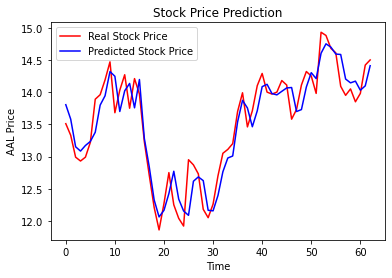

y_test_ori.shape (63, 1)
Epoch 1/500
3/3 [==============================] - 7s 64ms/step - loss: 0.4205
Epoch 2/500
3/3 [==============================] - 0s 72ms/step - loss: 0.3402
Epoch 3/500
3/3 [==============================] - 0s 77ms/step - loss: 0.2590
Epoch 4/500
3/3 [==============================] - 0s 81ms/step - loss: 0.2059
Epoch 5/500
3/3 [==============================] - 0s 77ms/step - loss: 0.2167
Epoch 6/500
3/3 [==============================] - 0s 76ms/step - loss: 0.1986
Epoch 7/500
3/3 [==============================] - 0s 80ms/step - loss: 0.1807
Epoch 8/500
3/3 [==============================] - 0s 77ms/step - loss: 0.1794
Epoch 9/500
3/3 [==============================] - 0s 77ms/step - loss: 0.1774
Epoch 10/500
3/3 [==============================] - 0s 78ms/step - loss: 0.1705
Epoch 11/500
3/3 [==============================] - 0s 78ms/step - loss: 0.1636
Epoch 12/500
3/3 [==============================] - 0s 75ms/step - loss: 0.1610
Epoch 13/500
3/3 [======

3/3 [==============================] - 0s 82ms/step - loss: 0.0878
Epoch 104/500
3/3 [==============================] - 0s 81ms/step - loss: 0.0879
Epoch 105/500
3/3 [==============================] - 0s 84ms/step - loss: 0.0880
Epoch 106/500
3/3 [==============================] - 0s 84ms/step - loss: 0.0873
Epoch 107/500
3/3 [==============================] - 0s 85ms/step - loss: 0.0878
Epoch 108/500
3/3 [==============================] - 0s 80ms/step - loss: 0.0873
Epoch 109/500
3/3 [==============================] - 0s 81ms/step - loss: 0.0871
Epoch 110/500
3/3 [==============================] - 0s 80ms/step - loss: 0.0870
Epoch 111/500
3/3 [==============================] - 0s 81ms/step - loss: 0.0869
Epoch 112/500
3/3 [==============================] - 0s 86ms/step - loss: 0.0872
Epoch 113/500
3/3 [==============================] - 0s 80ms/step - loss: 0.0871
Epoch 114/500
3/3 [==============================] - 0s 77ms/step - loss: 0.0864
Epoch 115/500
3/3 [=======================

3/3 [==============================] - 0s 83ms/step - loss: 0.0661
Epoch 306/500
3/3 [==============================] - 0s 86ms/step - loss: 0.0650
Epoch 307/500
3/3 [==============================] - 0s 86ms/step - loss: 0.0657
Epoch 308/500
3/3 [==============================] - 0s 84ms/step - loss: 0.0668
Epoch 309/500
3/3 [==============================] - 0s 81ms/step - loss: 0.0670
Epoch 310/500
3/3 [==============================] - 0s 87ms/step - loss: 0.0655
Epoch 311/500
3/3 [==============================] - 0s 84ms/step - loss: 0.0664
Epoch 312/500
3/3 [==============================] - 0s 84ms/step - loss: 0.0650
Epoch 313/500
3/3 [==============================] - 0s 84ms/step - loss: 0.0655
Epoch 314/500
3/3 [==============================] - 0s 85ms/step - loss: 0.0648
Epoch 315/500
3/3 [==============================] - 0s 85ms/step - loss: 0.0648
Epoch 316/500
3/3 [==============================] - 0s 84ms/step - loss: 0.0648
Epoch 317/500
3/3 [=======================

1/1 [==============================] - 0s 22ms/step
MSE [2.76529689]
accuracy [0.99100831]
mean_error_percent [0.00899169]


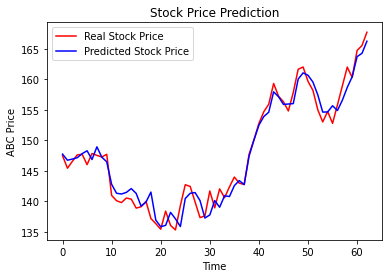

y_test_ori.shape (63, 1)
Epoch 1/500
3/3 [==============================] - 8s 76ms/step - loss: 0.4537
Epoch 2/500
3/3 [==============================] - 0s 84ms/step - loss: 0.3342
Epoch 3/500
3/3 [==============================] - 0s 84ms/step - loss: 0.2380
Epoch 4/500
3/3 [==============================] - 0s 78ms/step - loss: 0.2123
Epoch 5/500
3/3 [==============================] - 0s 85ms/step - loss: 0.2271
Epoch 6/500
3/3 [==============================] - 0s 83ms/step - loss: 0.1976
Epoch 7/500
3/3 [==============================] - 0s 80ms/step - loss: 0.1847
Epoch 8/500
3/3 [==============================] - 0s 80ms/step - loss: 0.1836
Epoch 9/500
3/3 [==============================] - 0s 82ms/step - loss: 0.1799
Epoch 10/500
3/3 [==============================] - 0s 86ms/step - loss: 0.1720
Epoch 11/500
3/3 [==============================] - 0s 81ms/step - loss: 0.1648
Epoch 12/500
3/3 [==============================] - 0s 80ms/step - loss: 0.1614
Epoch 13/500
3/3 [======

3/3 [==============================] - 0s 87ms/step - loss: 0.0690
Epoch 204/500
3/3 [==============================] - 0s 99ms/step - loss: 0.0668
Epoch 205/500
3/3 [==============================] - 0s 89ms/step - loss: 0.0685
Epoch 206/500
3/3 [==============================] - 0s 84ms/step - loss: 0.0666
Epoch 207/500
3/3 [==============================] - 0s 95ms/step - loss: 0.0674
Epoch 208/500
3/3 [==============================] - 0s 83ms/step - loss: 0.0672
Epoch 209/500
3/3 [==============================] - 0s 80ms/step - loss: 0.0662
Epoch 210/500
3/3 [==============================] - 0s 86ms/step - loss: 0.0666
Epoch 211/500
3/3 [==============================] - 0s 110ms/step - loss: 0.0663
Epoch 212/500
3/3 [==============================] - 0s 92ms/step - loss: 0.0660
Epoch 213/500
3/3 [==============================] - 0s 93ms/step - loss: 0.0663
Epoch 214/500
3/3 [==============================] - 0s 85ms/step - loss: 0.0659
Epoch 215/500
3/3 [======================

3/3 [==============================] - 0s 83ms/step - loss: 0.0605
Epoch 406/500
3/3 [==============================] - 0s 86ms/step - loss: 0.0606
Epoch 407/500
3/3 [==============================] - 0s 91ms/step - loss: 0.0605
Epoch 408/500
3/3 [==============================] - 0s 87ms/step - loss: 0.0605
Epoch 409/500
3/3 [==============================] - 0s 84ms/step - loss: 0.0607
Epoch 410/500
3/3 [==============================] - 0s 88ms/step - loss: 0.0606
Epoch 411/500
3/3 [==============================] - 0s 86ms/step - loss: 0.0605
Epoch 412/500
3/3 [==============================] - 0s 92ms/step - loss: 0.0606
Epoch 413/500
3/3 [==============================] - 0s 87ms/step - loss: 0.0605
Epoch 414/500
3/3 [==============================] - 0s 97ms/step - loss: 0.0607
Epoch 415/500
3/3 [==============================] - 0s 91ms/step - loss: 0.0613
Epoch 416/500
3/3 [==============================] - 0s 91ms/step - loss: 0.0606
Epoch 417/500
3/3 [=======================

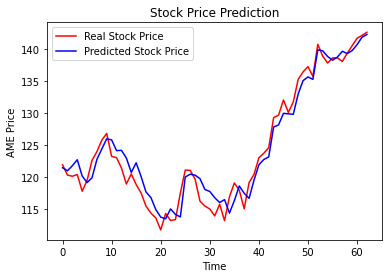

y_test_ori.shape (63, 1)
Epoch 1/500
3/3 [==============================] - 8s 121ms/step - loss: 0.4022
Epoch 2/500
3/3 [==============================] - 0s 100ms/step - loss: 0.3096
Epoch 3/500
3/3 [==============================] - 0s 94ms/step - loss: 0.2351
Epoch 4/500
3/3 [==============================] - 0s 89ms/step - loss: 0.2180
Epoch 5/500
3/3 [==============================] - 0s 106ms/step - loss: 0.2189
Epoch 6/500
3/3 [==============================] - 0s 87ms/step - loss: 0.1951
Epoch 7/500
3/3 [==============================] - 0s 88ms/step - loss: 0.1855
Epoch 8/500
3/3 [==============================] - 0s 91ms/step - loss: 0.1827
Epoch 9/500
3/3 [==============================] - 0s 85ms/step - loss: 0.1762
Epoch 10/500
3/3 [==============================] - 0s 95ms/step - loss: 0.1671
Epoch 11/500
3/3 [==============================] - 0s 90ms/step - loss: 0.1605
Epoch 12/500
3/3 [==============================] - 0s 87ms/step - loss: 0.1574
Epoch 13/500
3/3 [===

Epoch 103/500
3/3 [==============================] - 0s 102ms/step - loss: 0.0790
Epoch 104/500
3/3 [==============================] - 0s 91ms/step - loss: 0.0791
Epoch 105/500
3/3 [==============================] - 0s 87ms/step - loss: 0.0783
Epoch 106/500
3/3 [==============================] - 0s 87ms/step - loss: 0.0787
Epoch 107/500
3/3 [==============================] - 0s 86ms/step - loss: 0.0786
Epoch 108/500
3/3 [==============================] - 0s 91ms/step - loss: 0.0781
Epoch 109/500
3/3 [==============================] - 0s 88ms/step - loss: 0.0785
Epoch 110/500
3/3 [==============================] - 0s 86ms/step - loss: 0.0789
Epoch 111/500
3/3 [==============================] - 0s 88ms/step - loss: 0.0784
Epoch 112/500
3/3 [==============================] - 0s 95ms/step - loss: 0.0791
Epoch 113/500
3/3 [==============================] - 0s 90ms/step - loss: 0.0790
Epoch 114/500
3/3 [==============================] - 0s 86ms/step - loss: 0.0783
Epoch 115/500
3/3 [========

3/3 [==============================] - 0s 86ms/step - loss: 0.0636
Epoch 205/500
3/3 [==============================] - 0s 89ms/step - loss: 0.0644
Epoch 206/500
3/3 [==============================] - 0s 90ms/step - loss: 0.0628
Epoch 207/500
3/3 [==============================] - 0s 94ms/step - loss: 0.0626
Epoch 208/500
3/3 [==============================] - 0s 88ms/step - loss: 0.0632
Epoch 209/500
3/3 [==============================] - 0s 88ms/step - loss: 0.0633
Epoch 210/500
3/3 [==============================] - 0s 85ms/step - loss: 0.0631
Epoch 211/500
3/3 [==============================] - 0s 90ms/step - loss: 0.0625
Epoch 212/500
3/3 [==============================] - 0s 90ms/step - loss: 0.0624
Epoch 213/500
3/3 [==============================] - 0s 88ms/step - loss: 0.0632
Epoch 214/500
3/3 [==============================] - 0s 86ms/step - loss: 0.0625
Epoch 215/500
3/3 [==============================] - 0s 86ms/step - loss: 0.0625
Epoch 216/500
3/3 [=======================

3/3 [==============================] - 0s 86ms/step - loss: 0.0554
Epoch 407/500
3/3 [==============================] - 0s 86ms/step - loss: 0.0552
Epoch 408/500
3/3 [==============================] - 0s 91ms/step - loss: 0.0558
Epoch 409/500
3/3 [==============================] - 0s 86ms/step - loss: 0.0550
Epoch 410/500
3/3 [==============================] - 0s 86ms/step - loss: 0.0555
Epoch 411/500
3/3 [==============================] - 0s 87ms/step - loss: 0.0559
Epoch 412/500
3/3 [==============================] - 0s 85ms/step - loss: 0.0548
Epoch 413/500
3/3 [==============================] - 0s 82ms/step - loss: 0.0554
Epoch 414/500
3/3 [==============================] - 0s 89ms/step - loss: 0.0552
Epoch 415/500
3/3 [==============================] - 0s 87ms/step - loss: 0.0553
Epoch 416/500
3/3 [==============================] - 0s 91ms/step - loss: 0.0553
Epoch 417/500
3/3 [==============================] - 0s 92ms/step - loss: 0.0548
Epoch 418/500
3/3 [=======================

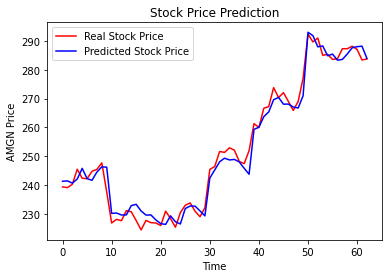

y_test_ori.shape (63, 1)
Epoch 1/500
3/3 [==============================] - 10s 95ms/step - loss: 0.4487
Epoch 2/500
3/3 [==============================] - 0s 98ms/step - loss: 0.3495
Epoch 3/500
3/3 [==============================] - 0s 97ms/step - loss: 0.2592
Epoch 4/500
3/3 [==============================] - 0s 98ms/step - loss: 0.2067
Epoch 5/500
3/3 [==============================] - 0s 179ms/step - loss: 0.2235
Epoch 6/500
3/3 [==============================] - 0s 111ms/step - loss: 0.2009
Epoch 7/500
3/3 [==============================] - 0s 97ms/step - loss: 0.1821
Epoch 8/500
3/3 [==============================] - 0s 94ms/step - loss: 0.1815
Epoch 9/500
3/3 [==============================] - 0s 172ms/step - loss: 0.1799
Epoch 10/500
3/3 [==============================] - 0s 105ms/step - loss: 0.1719
Epoch 11/500
3/3 [==============================] - 0s 101ms/step - loss: 0.1637
Epoch 12/500
3/3 [==============================] - 0s 106ms/step - loss: 0.1605
Epoch 13/500
3/3 

3/3 [==============================] - 0s 87ms/step - loss: 0.0673
Epoch 204/500
3/3 [==============================] - 0s 90ms/step - loss: 0.0655
Epoch 205/500
3/3 [==============================] - 0s 87ms/step - loss: 0.0684
Epoch 206/500
3/3 [==============================] - 0s 85ms/step - loss: 0.0657
Epoch 207/500
3/3 [==============================] - 0s 87ms/step - loss: 0.0650
Epoch 208/500
3/3 [==============================] - 0s 85ms/step - loss: 0.0642
Epoch 209/500
3/3 [==============================] - 0s 92ms/step - loss: 0.0647
Epoch 210/500
3/3 [==============================] - 0s 86ms/step - loss: 0.0647
Epoch 211/500
3/3 [==============================] - 0s 90ms/step - loss: 0.0639
Epoch 212/500
3/3 [==============================] - 0s 82ms/step - loss: 0.0639
Epoch 213/500
3/3 [==============================] - 0s 92ms/step - loss: 0.0641
Epoch 214/500
3/3 [==============================] - 0s 82ms/step - loss: 0.0648
Epoch 215/500
3/3 [=======================

3/3 [==============================] - 0s 82ms/step - loss: 0.0592
Epoch 406/500
3/3 [==============================] - 0s 86ms/step - loss: 0.0582
Epoch 407/500
3/3 [==============================] - 0s 85ms/step - loss: 0.0580
Epoch 408/500
3/3 [==============================] - 0s 86ms/step - loss: 0.0586
Epoch 409/500
3/3 [==============================] - 0s 86ms/step - loss: 0.0588
Epoch 410/500
3/3 [==============================] - 0s 90ms/step - loss: 0.0592
Epoch 411/500
3/3 [==============================] - 0s 87ms/step - loss: 0.0588
Epoch 412/500
3/3 [==============================] - 0s 86ms/step - loss: 0.0583
Epoch 413/500
3/3 [==============================] - 0s 87ms/step - loss: 0.0600
Epoch 414/500
3/3 [==============================] - 0s 87ms/step - loss: 0.0588
Epoch 415/500
3/3 [==============================] - 0s 91ms/step - loss: 0.0580
Epoch 416/500
3/3 [==============================] - 0s 87ms/step - loss: 0.0583
Epoch 417/500
3/3 [=======================

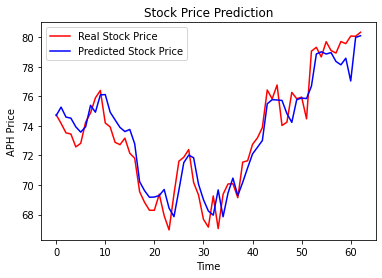

y_test_ori.shape (63, 1)
Epoch 1/500
3/3 [==============================] - 8s 104ms/step - loss: 0.4293
Epoch 2/500
3/3 [==============================] - 0s 92ms/step - loss: 0.3420
Epoch 3/500
3/3 [==============================] - 0s 99ms/step - loss: 0.2550
Epoch 4/500
3/3 [==============================] - 0s 97ms/step - loss: 0.2068
Epoch 5/500
3/3 [==============================] - 0s 90ms/step - loss: 0.2163
Epoch 6/500
3/3 [==============================] - 0s 90ms/step - loss: 0.1953
Epoch 7/500
3/3 [==============================] - 0s 85ms/step - loss: 0.1798
Epoch 8/500
3/3 [==============================] - 0s 88ms/step - loss: 0.1769
Epoch 9/500
3/3 [==============================] - 0s 106ms/step - loss: 0.1726
Epoch 10/500
3/3 [==============================] - 0s 97ms/step - loss: 0.1651
Epoch 11/500
3/3 [==============================] - 0s 88ms/step - loss: 0.1598
Epoch 12/500
3/3 [==============================] - 0s 82ms/step - loss: 0.1571
Epoch 13/500
3/3 [====

3/3 [==============================] - 0s 106ms/step - loss: 0.0801
Epoch 104/500
3/3 [==============================] - 0s 95ms/step - loss: 0.0796
Epoch 105/500
3/3 [==============================] - 0s 87ms/step - loss: 0.0793
Epoch 106/500
3/3 [==============================] - 0s 85ms/step - loss: 0.0793
Epoch 107/500
3/3 [==============================] - 0s 99ms/step - loss: 0.0794
Epoch 108/500
3/3 [==============================] - 0s 91ms/step - loss: 0.0795
Epoch 109/500
3/3 [==============================] - 0s 91ms/step - loss: 0.0794
Epoch 110/500
3/3 [==============================] - 0s 97ms/step - loss: 0.0793
Epoch 111/500
3/3 [==============================] - 0s 98ms/step - loss: 0.0793
Epoch 112/500
3/3 [==============================] - 0s 140ms/step - loss: 0.0795
Epoch 113/500
3/3 [==============================] - 0s 94ms/step - loss: 0.0793
Epoch 114/500
3/3 [==============================] - 0s 89ms/step - loss: 0.0793
Epoch 115/500
3/3 [=====================

KeyboardInterrupt: 

In [6]:
#this may take a long time
for symbol in company_symbol:
    y_test_ori,de_predicted=stock_price_pridict(sp50_data,symbol)
    close_true[symbol]=y_test_ori
    close_predict[symbol]=de_predicted

In [ ]:
close_true

In [ ]:
close_predict

### Step 4: Plot for several companies.

In [ ]:
f, ((ax1,ax2,ax3),(ax4,ax5,ax6),(ax7,ax8,ax9),(ax10,non1,non2)) = plt.subplots(4, 3, figsize=(20,15))

ax1.plot(close_true['A'], color = 'red', label = 'Real Stock Price')
ax1.plot(close_predict['A'], color = 'blue', label = 'Predicted Stock Price')
ax1.legend()
mse=((close_true['A']-close_predict['A'])**2).mean()
ax1.set_title(f'Stock Prediction of A with MSE {mse}')

ax2.plot(close_true['ALLE'], color = 'red', label = 'Real Stock Price')
ax2.plot(close_predict['ALLE'], color = 'blue', label = 'Predicted Stock Price')
ax2.legend()
mse=((close_true['ALLE']-close_predict['ALLE'])**2).mean()
ax2.set_title(f'Stock Prediction of ALLE with MSE {mse}')

ax3.plot(close_true['AMGN'], color = 'red', label = 'Real Stock Price')
ax3.plot(close_predict['AMGN'], color = 'blue', label = 'Predicted Stock Price')
ax3.legend()
mse=((close_true['AMGN']-close_predict['AMGN'])**2).mean()
ax3.set_title(f'Stock Prediction of AMGN with MSE {mse}')

ax4.plot(close_true['BIIB'], color = 'red', label = 'Real Stock Price')
ax4.plot(close_predict['BIIB'], color = 'blue', label = 'Predicted Stock Price')
ax4.legend()
mse=((close_true['BIIB']-close_predict['BIIB'])**2).mean()
ax4.set_title(f'Stock Prediction of BIIB with MSE {mse}')

ax5.plot(close_true['BMY'], color = 'red', label = 'Real Stock Price')
ax5.plot(close_predict['BMY'], color = 'blue', label = 'Predicted Stock Price')
ax5.legend()
mse=((close_true['BMY']-close_predict['BMY'])**2).mean()
ax5.set_title(f'Stock Prediction of BMY with MSE {mse}')

ax6.plot(close_true['CAT'], color = 'red', label = 'Real Stock Price')
ax6.plot(close_predict['CAT'], color = 'blue', label = 'Predicted Stock Price')
ax5.legend()
mse=((close_true['CAT']-close_predict['CAT'])**2).mean()
ax6.set_title(f'Stock Prediction of CAT with MSE {mse}')

ax7.plot(close_true['ATVI'], color = 'red', label = 'Real Stock Price')
ax7.plot(close_predict['ATVI'], color = 'blue', label = 'Predicted Stock Price')
ax7.legend()
mse=((close_true['ATVI']-close_predict['ATVI'])**2).mean()
ax7.set_title(f'Stock Prediction of ATVI with MSE {mse}')

ax8.plot(close_true['BDX'], color = 'red', label = 'Real Stock Price')
ax8.plot(close_predict['BDX'], color = 'blue', label = 'Predicted Stock Price')
ax8.legend()
mse=((close_true['BDX']-close_predict['BDX'])**2).mean()
ax8.set_title(f'Stock Prediction of BDX with MSE {mse}')

ax9.plot(close_true['CHRW'], color = 'red', label = 'Real Stock Price')
ax9.plot(close_predict['CHRW'], color = 'blue', label = 'Predicted Stock Price')
ax9.legend()
mse=((close_true['CHRW']-close_predict['CHRW'])**2).mean()
ax9.set_title(f'Stock Prediction of CHRW with MSE {mse}')

ax10.plot(close_true['CHD'], color = 'red', label = 'Real Stock Price')
ax10.plot(close_predict['CHD'], color = 'blue', label = 'Predicted Stock Price')
ax10.legend()
mse=((close_true['CHD']-close_predict['CHD'])**2).mean()
ax10.set_title(f'Stock Prediction of CHD with MSE {mse}')

non1.xaxis.set_visible(False)
non1.yaxis.set_visible(False)
non1.spines['top'].set_visible(False)
non1.spines['left'].set_visible(False)
non1.spines['right'].set_visible(False)
non1.spines['bottom'].set_visible(False)

non2.xaxis.set_visible(False)
non2.yaxis.set_visible(False)
non2.spines['top'].set_visible(False)
non2.spines['left'].set_visible(False)
non2.spines['right'].set_visible(False)
non2.spines['bottom'].set_visible(False)

plt.show()

### Step 5: Correlation plot within sectors.

There do exist correlations within sectors of stock prices.

In [8]:
data_close=pd.DataFrame(data=None,columns=company_symbol)
for i in range(50):
    data_close[company_symbol[i]]=sp50_data[company_symbol[i]].loc[:,'Close']

company_industrial=sp50[sp50['GICS Sector']==sectors[0]]['Symbol']
company_health_care=sp50[sp50['GICS Sector']==sectors[1]]['Symbol']
company_it=sp50[sp50['GICS Sector']==sectors[2]]['Symbol']
company_communication_services=sp50[sp50['GICS Sector']==sectors[3]]['Symbol']
company_consumer_staples=sp50[sp50['GICS Sector']==sectors[4]]['Symbol']

data_industrial=data_close[company_industrial]
data_health_care=data_close[company_health_care]
data_it=data_close[company_it]
data_communication_services=data_close[company_communication_services]
data_consumer_staples=data_close[company_consumer_staples]

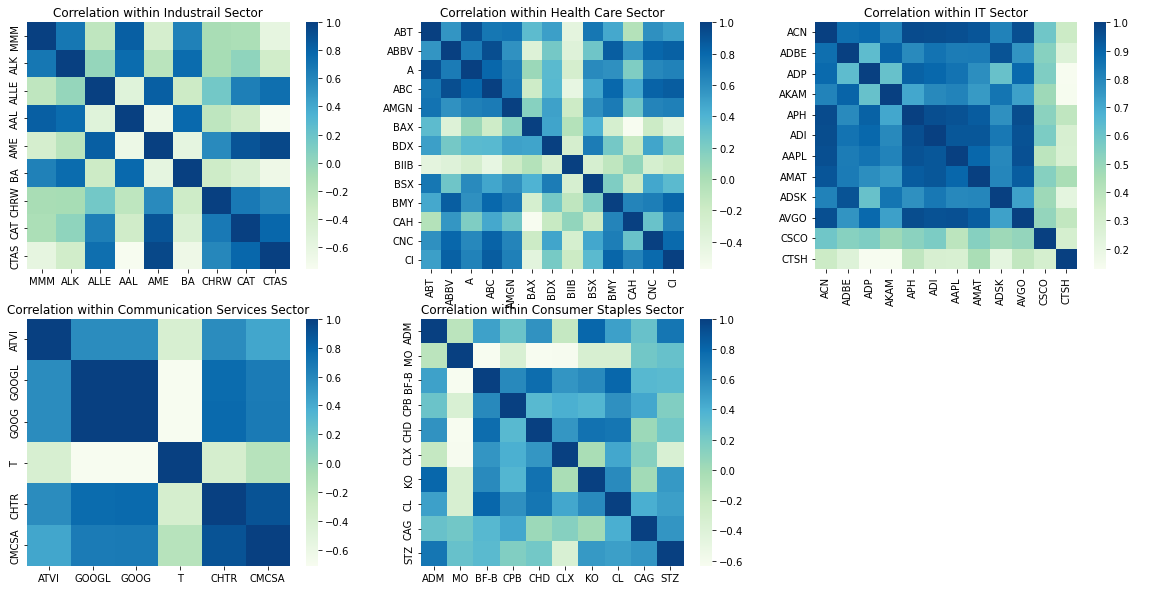

In [9]:
import seaborn as sns
f, ((industrial,health_care,it),(communication_services,consumer_staples,non)) = plt.subplots(2, 3, figsize=(20,10))

sns.heatmap(data_industrial.corr(),ax=industrial, cmap = 'GnBu')
industrial.set_title('Correlation within Industrail Sector')

sns.heatmap(data_health_care.corr(),ax=health_care, cmap = 'GnBu')
health_care.set_title('Correlation within Health Care Sector')

sns.heatmap(data_it.corr(),ax=it, cmap = 'GnBu')
it.set_title('Correlation within IT Sector')

sns.heatmap(data_communication_services.corr(),ax=communication_services, cmap = 'GnBu')
communication_services.set_title('Correlation within Communication Services Sector')

sns.heatmap(data_consumer_staples.corr(),ax=consumer_staples, cmap = 'GnBu')
consumer_staples.set_title('Correlation within Consumer Staples Sector')

non.xaxis.set_visible(False)
non.yaxis.set_visible(False)
non.spines['top'].set_visible(False)
non.spines['left'].set_visible(False)
non.spines['right'].set_visible(False)
non.spines['bottom'].set_visible(False)

plt.show()

### Step 6: ACF of MMM.

LSTM has a certain hysteresis in predicting the real data, which may be due to the autocorrelation of sequence samples.

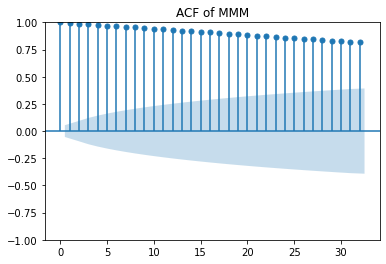

In [10]:
import statsmodels.api as sm
sm.graphics.tsa.plot_acf(data_industrial['MMM'])
plt.title('ACF of MMM')
plt.show()

In [12]:
pd.DataFrame(close_true).to_csv('/Users/happysherry/Desktop/close_true.csv')

In [13]:
pd.DataFrame(close_predict).to_csv('/Users/happysherry/Desktop/close_predict.csv')

In [14]:
return_predict=pd.DataFrame()
for symbol in company_symbol:
    return_predict[symbol]=np.log(close_predict[symbol]/close_predict[symbol].shift(1))

### Step 7: Define a function to calculate the return, risk and sharpe ratio based on given weights of 50 companies.

In [55]:
def statistics(weights):
    weights = np.array(weights)
    pret = np.sum(return_predict.mean() * weights)*65
    pvol = np.sqrt(np.dot(weights.T,
                          np.dot(return_predict.cov()*65,weights)))
    pvol1 = -norm.ppf(0.025,pret,pvol)
    return np.array([pret,pvol1,pret/pvol1,pret/pvol])

In [59]:
statistics(50*[1./50])

array([0.0308125 , 0.13416108, 0.22966798])

### Step 8: Set the constraint function.

- The sum of weigths equals to 1.
- Set the bounds (0,1) of variable to find the optimization.

In [18]:
cons=({'type':'eq','fun':lambda x: np.sum(x)-1})
bnds = tuple((0,1) for x in range(50))

### Step 9: Define a function to return the sharpe ratio based on the given weights.

It's for maximizing the profit.

In [52]:
def max_func_sharpe(weights):
    return -statistics(weights)[2]

In [56]:
opts = sco.minimize(max_func_sharpe,50*[1./50],method = 'SLSQP',
                   bounds = bnds, constraints = cons)

### Step 10: Output the weight vector.

Select the companies whose weights are non-zero.

In [57]:
opts['x'].round(3)
ww=list(opts['x'].round(3))
com=list(company_symbol)
see=pd.DataFrame({'com':com,'ww':ww})
see[see['ww']>0]

,com,ww
8,A,0.335
11,ALLE,0.116
18,AMGN,0.302
27,BIIB,0.066
30,BMY,0.121
36,CAT,0.066


In [50]:
statistics(opts['x'].round(3))

array([1.94603425e-01, 8.83567941e-04, 2.20247267e+02])

### Step 11: Define a function to return the sharpe ratio based on the given weights.

It's for minimizing the profit

In [ ]:
def min_func_sharpe(weights):
    return statistics(weights)[3]

In [ ]:
mins = sco.minimize(min_func_sharpe,50*[1./50],method = 'SLSQP',
                   bounds = bnds, constraints = cons)

### Step 12: Output the weight vector.

Select the companies whose weights are non-zero.

In [ ]:
ww1=list(mins['x'].round(2))
com1=list(company_symbol)
see1=pd.DataFrame({'com':com1,'ww':ww1})
see1[see1['ww']>0]